# Introduction

The purpose of this notebook is to show some simple transformations that allow out of box non-parametric L2 regressors to achieve better SMAPE scores. By default, these algorithms are not optimizing for a better SMAPE score. However, by changing the target variables by an invertible transformation, we can get these algorithms to get closer to optimizing SMAPE. However a transformation alone won't make the algorithm actually optimize on SMAPE. Furthermore, fitting on transformed target variables will change a parametric model (e.g. linear regression), but a non-parametric model (e.g. decision tree or neural network) will be okay as it has no strict structure.

For this notebook, we will be using a simple decision tree for our model.

# Imports

Imports that we will need.

In [14]:
import pandas as pd # Reading csv file
import numpy as np # Linear algebra
from matplotlib import pyplot as plt # Graphing
from sklearn.model_selection import train_test_split # We will do a simple train, validate, test split.
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# SMAPE Investigation

We won't go into great detail here as there are great resources elsewhere, but here we will just take a look at the nature of SMAPE. First we note that SMAPE measures an average of |p - t| / (|p| + |t|) for scalars p and t. Here, we think of p as being a predicted value and t being a true value. Furthermore, this quantity depends only on the ratio of p and t (with exception being when either are zero). So, let p = r * t. The quantity becomes a function of the single variable r, |1 - r| / (1 + |r|). Let us graph this function for non-negative ratios r.

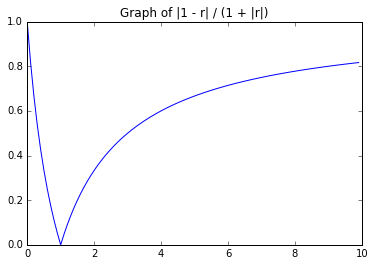

In [7]:
def ratioSMAPE(r):
    return np.abs(1 - r) / (1 + np.abs(r))

rvals = np.arange(0, 10, 0.1)
plt.plot(rvals, ratioSMAPE(rvals))
plt.title('Graph of |1 - r| / (1 + |r|)')
plt.show()

From the graph we see that when the true values are non-negative (as is the case in our data), we have the following:
* SMAPE punishes underpredictions more than over predictions. 
* As the prediction gets closer closer to 0, the SMAPE error approaches 1. 
* For over predicitions, as the size of the prediction gets really large, the SMAPE error again approaches 1.

We use these properties to guide us towards finding some transformation functions z = f(y) that will let an L2 regression for target z values more closely emulate minimizing SMAPE.

# Get the Data

In [8]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

For this notebook, we wish to concentrate on just getting better regression results. So we will simply set every NaN value to 0.

In [9]:
# Set all NaN to 0.

all_df.fillna(0, inplace = True)

# Dividing the data

The competition has us predicting values 64 days into the future. To measure the accuracy of our models, we will simply let the last 64 days of our training data be the target values Y to predict using the data from the previous days X. Also, this notebook is meant to be as simple as possible, so we will not look at extracting features from the Page data. So we will only be using the time series data.

In [11]:
# Separate into training data into features and targets.

futureT = 64
X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

For simplicity, we will split our data into a training set, a validation set, and a test set.

In [12]:
# First split into test and a combination of training and validation.

X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)

# Now split up the training and validation sets.

X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


# Set up SMAPE error function

Now we define a SMAPE error function that we will use through out the rest of the notebook.

In [13]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

# Normal L2 Regression Benchmark

Here we do a simple L2 Regression using a decision tree on the mean of sample over the entire time history of the time series.

In [39]:
model = Pipeline([ ('means', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
test_smape = {} # We will be storing all of the results of our tests for comparison in a dictionary.
test_smape['benchmark'] = smape(Y_predict, Y_test)
print('SMAPE = ', test_smape['benchmark'])

SMAPE =  109.99937889


# Z Transformation Regressions

Now we use simple functions f(Y) to make new target variables Z = f(Y). Then we do regression using the transformed targets Z. To compute the SMAPE score, we invert to get the predicted Y values and then compute the SMAPE score.

For each function f(Y), we will actually search over a hyper-parameter to minimize the SMAPE score.

## First Z Transformation

To motivate the first Z transformation, we consider the mean of the Y values, Y_mean. We plug it into the formula for each term in SMAPE, and we get an average of |y - Y_mean| / (|y| + Y_mean). Fix Y_mean to be a constant C and consider this to be a function of y, that is f(y) = |y - C| / (|y| + C). Now, we should have non-negative y so should be able to ignore the absolute values in the denominator. Let us also ignore the absolute value in the numerator (you can kind of justify this by the fact that the squared nature of L2 means we should have ignored the absolute value from the very beginning). So we are lead to z = f(y) = (y - C) / (y + C) = 1 - 2C / ( y + C ).

Now, doing L2 regression for this z is the same as doing L2 regression for the slightly different f(y) = 1 / (y + C) (which we probably could have simply guessed from the very beginning). This has the nice property of making smaller values larger and therefore more punishing for differences in small values. Furthermore, f(y) goes to zero as y gets really large (the main point being it approaches a bounded value).

In [24]:
# definition of ztransformation.

def ztransform1(Y, param):
    return 1 / (param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ1(Z, param):
    return -param + 1 / Z

Now let us try searching for the optimal value of C to minimize the SMAPE score when doing L2 regression on Z. We will do a simple grid search.

Now, sometimes our fit will give a predicted value of 0 while the true value is 0. Our SMAPE function is simple and so it will return a NaN value. Let's bypass this by adding a small value of epsilon to the predicted Y values that will not affect the SMAPE score that much.

param =  20  smape =  98.6365935853 ,	param =  40  smape =  96.0750204123 ,	param =  60  smape =  94.5639738655 ,	param =  80  smape =  93.8730572696 ,	param =  100  smape =  93.3030969316 ,	param =  120  smape =  92.9237584172 ,	param =  140  smape =  92.6506442279 ,	param =  160  smape =  92.4331047777 ,	param =  180  smape =  92.2911423756 ,	param =  200  smape =  92.1735298355 ,	param =  220  smape =  92.0450042187 ,	param =  240  smape =  91.9084865072 ,	param =  260  smape =  92.0294132484 ,	param =  280  smape =  92.5663491609 ,	param =  300  smape =  93.8109376555 ,	param =  320  smape =  93.7315037616 ,	param =  340  smape =  93.727053272 ,	param =  360  smape =  94.3536442001 ,	param =  380  smape =  94.3806748832 ,	param =  400  smape =  97.3747918138 ,	

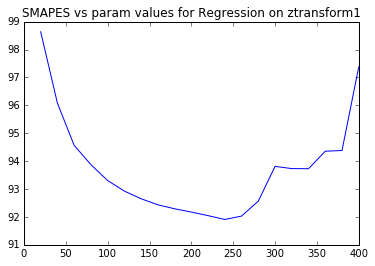

In [35]:
# Values to try for param.

param_search = np.arange(20, 420, 20)

# To record results of fits

smapes = []
epsilon = 1e-6

for param in param_search:
    Z_train = ztransform1(Y_train, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ1(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('param = ', param, ' smape = ', newsmape, ',\t', end = '')
    
plt.plot(param_search, smapes)
plt.title('SMAPES vs param values for Regression on ztransform1')
plt.show()
    

Now let's do a test for param = 240. We will train on all of the training and validation data.

In [40]:
param = 240
Z_trainvalid = ztransform1(Y_trainvalid, param)
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = inverseZ1(Z_predict, param)
test_smape['z1'] = smape(epsilon + Y_predict, Y_test)
print('SMAPE = ', test_smape['z1'])

SMAPE =  91.4970374422
